# 5. Phân tích đa biến (Multivariate Analysis)

Trong notebook này, chúng ta sẽ thực hiện phân tích mối quan hệ giữa các biến và trực quan hóa sự phân bố của dữ liệu để đánh giá khả năng phân tách giữa các nhóm bài viết. Mục tiêu là kiểm tra tính chất cụm của dữ liệu và mối tương quan giữa các đặc trưng.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import os

# Thiết lập để hiển thị biểu đồ đẹp hơn
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Để hiển thị Tiếng Việt đúng
plt.rcParams['font.family'] = 'DejaVu Sans'

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Đọc dữ liệu đã xây dựng đặc trưng
df = pd.read_csv('../clean_data/vnexpress_featured_data.csv', encoding='utf-8-sig')

print(f"Kích thước dữ liệu: {df.shape}")
print(f"Các cột trong dữ liệu: {df.columns[:10].tolist()}...")
print(f"Phân bố nhóm bài viết:\n{df['group'].value_counts()}")

Kích thước dữ liệu: (1182, 80)
Các cột trong dữ liệu: ['tfidf_phẩm', 'category_Thiết bị', 'tfidf_tháng', 'tag_iphone', 'tfidf_dụng', 'tfidf_học', 'tag_tàu_vũ_trụ', 'tfidf_dùng', 'category_Tin tức', 'category_Trắc nghiệm']...
Phân bố nhóm bài viết:
group
Công nghệ    604
Khoa học     578
Name: count, dtype: int64


In [3]:
df.head()

,tfidf_phẩm,category_Thiết bị,tfidf_tháng,tag_iphone,tfidf_dụng,tfidf_học,tag_tàu_vũ_trụ,tfidf_dùng,category_Tin tức,category_Trắc nghiệm,...,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10
0,0.000000,0.0,0.019806,0,0.014983,0.074223,0,0.058456,0.0,0.0,...,-0.819031,0.743379,1.236353,-1.585730,-0.646279,-1.139843,0.121434,-0.900328,-0.785398,0.336775
1,0.117225,1.0,0.000000,0,0.018904,0.000000,0,0.024585,0.0,0.0,...,0.452235,1.284967,-1.881938,2.573106,0.143488,0.935204,-1.249072,-0.845481,0.058678,-0.295745
2,0.027961,1.0,0.047686,0,0.000000,0.000000,0,0.023456,0.0,0.0,...,-4.616722,4.458460,-3.879631,2.157636,1.727752,-2.495130,6.851244,0.571943,-0.781902,1.575584
3,0.047988,0.0,0.027280,0,0.000000,0.000000,0,0.013419,0.0,0.0,...,-0.703083,0.677755,-1.185655,-1.054359,1.302111,-0.614572,-0.420291,0.545768,0.342521,-0.459644
4,0.000000,0.0,0.014580,0,0.000000,0.040978,0,0.000000,0.0,0.0,...,-0.307545,1.008614,1.758528,-2.008925,-1.344776,1.158228,0.475385,3.743796,0.513712,0.852086


## 5.1. Phân tích tương quan giữa các đặc trưng

Chúng ta sẽ sử dụng ma trận tương quan (correlation matrix) để xác định các đặc trưng có mối quan hệ mạnh với nhau và với biến mục tiêu.

In [16]:
# Tạo một cột nhị phân cho biến mục tiêu (target)
df['target'] = (df['group'] == 'Công nghệ').astype(int)

# Chọn các đặc trưng kỹ thuật và các thành phần PCA
engineered_features = ['title_content_ratio', 'desc_content_ratio', 'comments_per_content_length', 
                      'is_weekend', 'text_complexity']
pca_features = [col for col in df.columns if col.startswith('pca_')]

# Lọc và chọn một số đặc trưng TF-IDF có ý nghĩa nhất
tfidf_features = [col for col in df.columns if col.startswith('tfidf_')]
important_tfidf = tfidf_features[:10]  # Chỉ lấy 10 đặc trưng TF-IDF đầu tiên

# Tính toán ma trận tương quan
features_for_correlation = engineered_features + pca_features + important_tfidf + ['target']
correlation_matrix = df[features_for_correlation].corr()

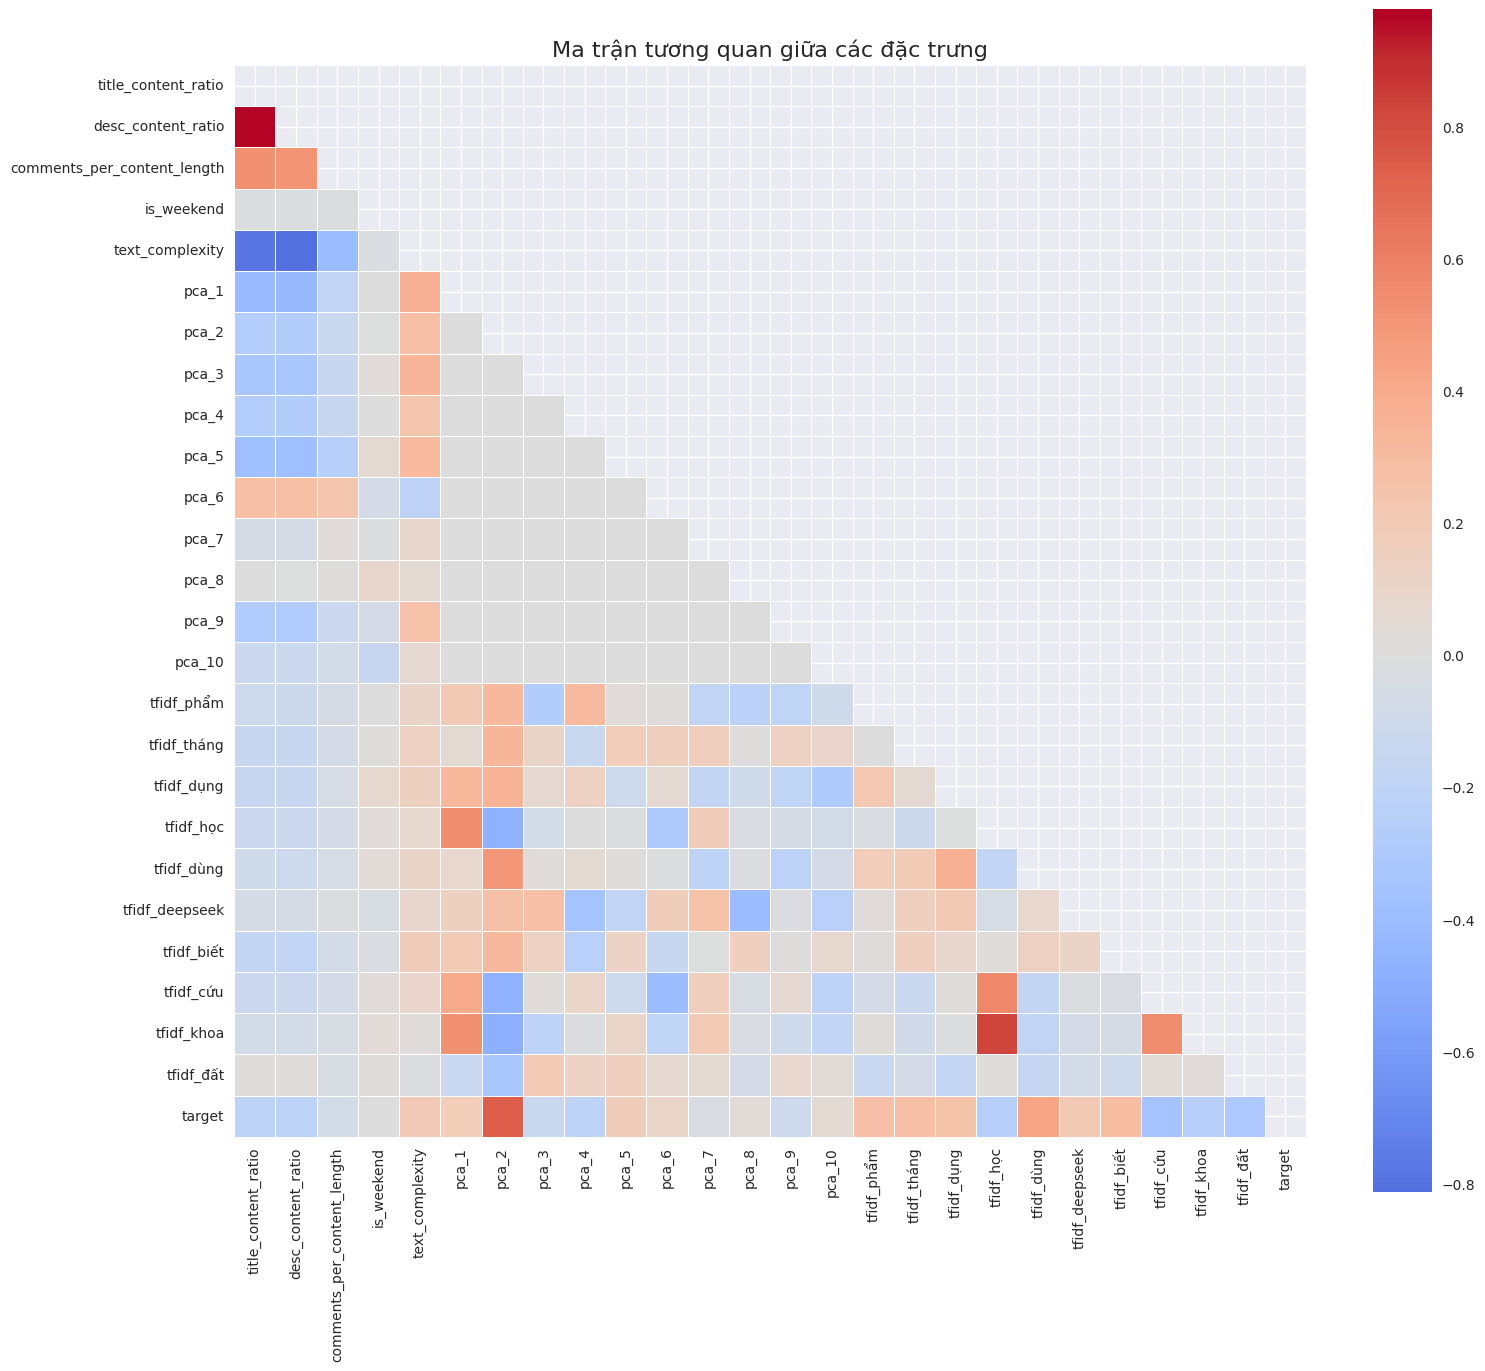

In [17]:
# Trực quan hóa ma trận tương quan với heatmap
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(correlation_matrix))
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=False, 
            cmap='coolwarm', 
            center=0,
            linewidths=0.5,
            square=True)
plt.title('Ma trận tương quan giữa các đặc trưng', fontsize=16)
plt.tight_layout()
plt.show()

### 5.1.1. Đặc trưng có tương quan mạnh với biến mục tiêu

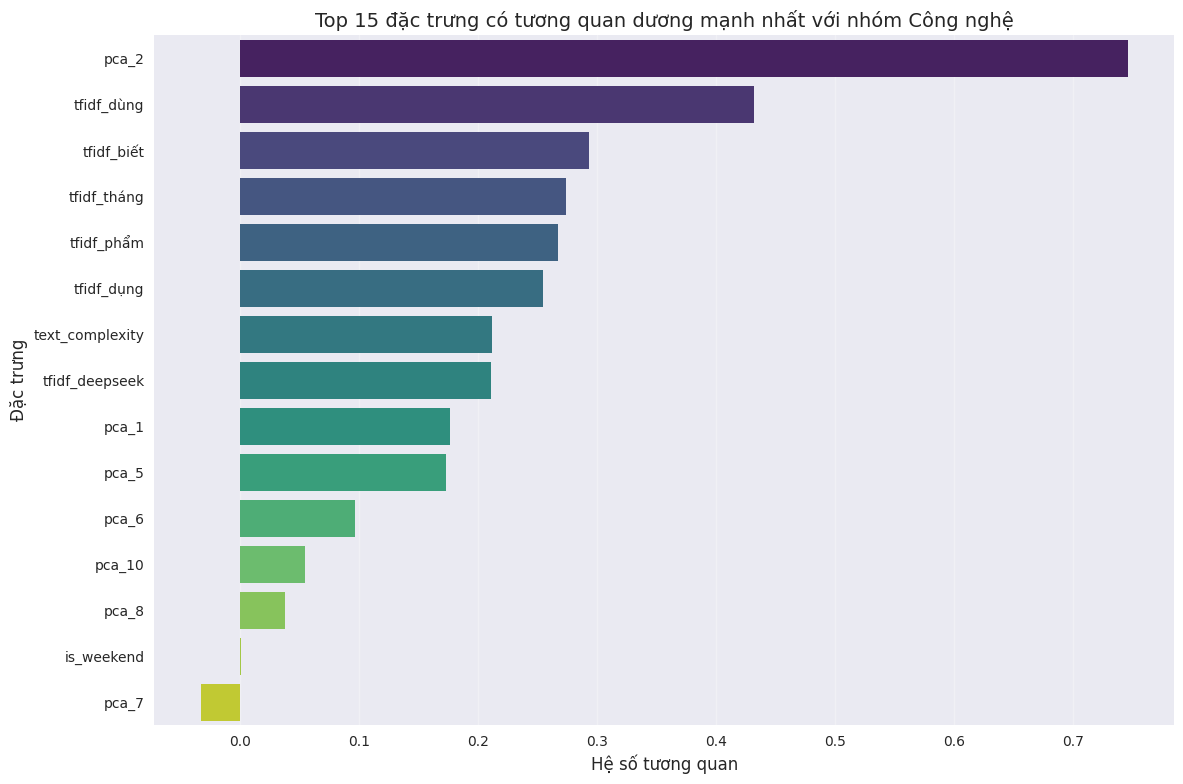

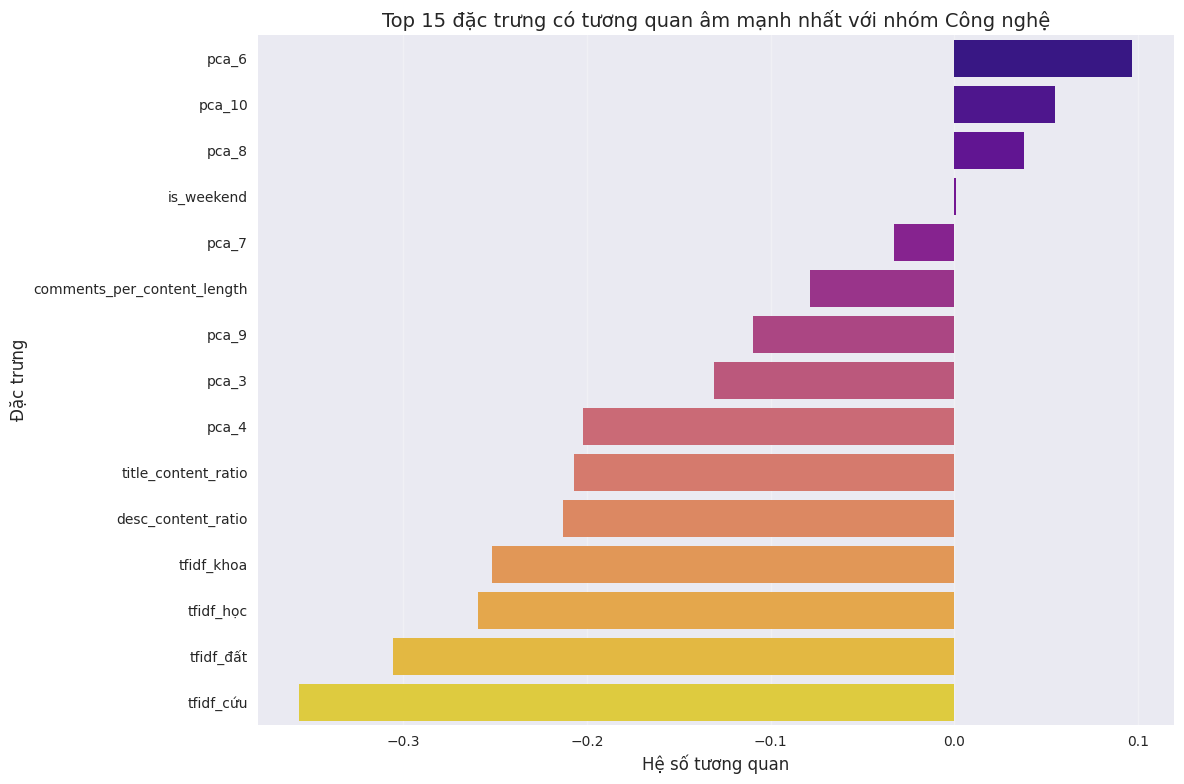

In [18]:
# Tìm đặc trưng có tương quan mạnh với biến mục tiêu
target_correlation = correlation_matrix['target'].drop('target').sort_values(ascending=False)

# Hiển thị top 15 đặc trưng có tương quan mạnh nhất với biến mục tiêu
plt.figure(figsize=(12, 8))
sns.barplot(x=target_correlation.head(15).values, y=target_correlation.head(15).index, palette='viridis')
plt.title('Top 15 đặc trưng có tương quan dương mạnh nhất với nhóm Công nghệ', fontsize=14)
plt.xlabel('Hệ số tương quan', fontsize=12)
plt.ylabel('Đặc trưng', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x=target_correlation.tail(15).values, y=target_correlation.tail(15).index, palette='plasma')
plt.title('Top 15 đặc trưng có tương quan âm mạnh nhất với nhóm Công nghệ', fontsize=14)
plt.xlabel('Hệ số tương quan', fontsize=12)
plt.ylabel('Đặc trưng', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 5.2. Phân tích mối quan hệ giữa các cặp đặc trưng

Chúng ta sẽ xem xét mối quan hệ giữa các cặp đặc trưng quan trọng thông qua scatter plot.

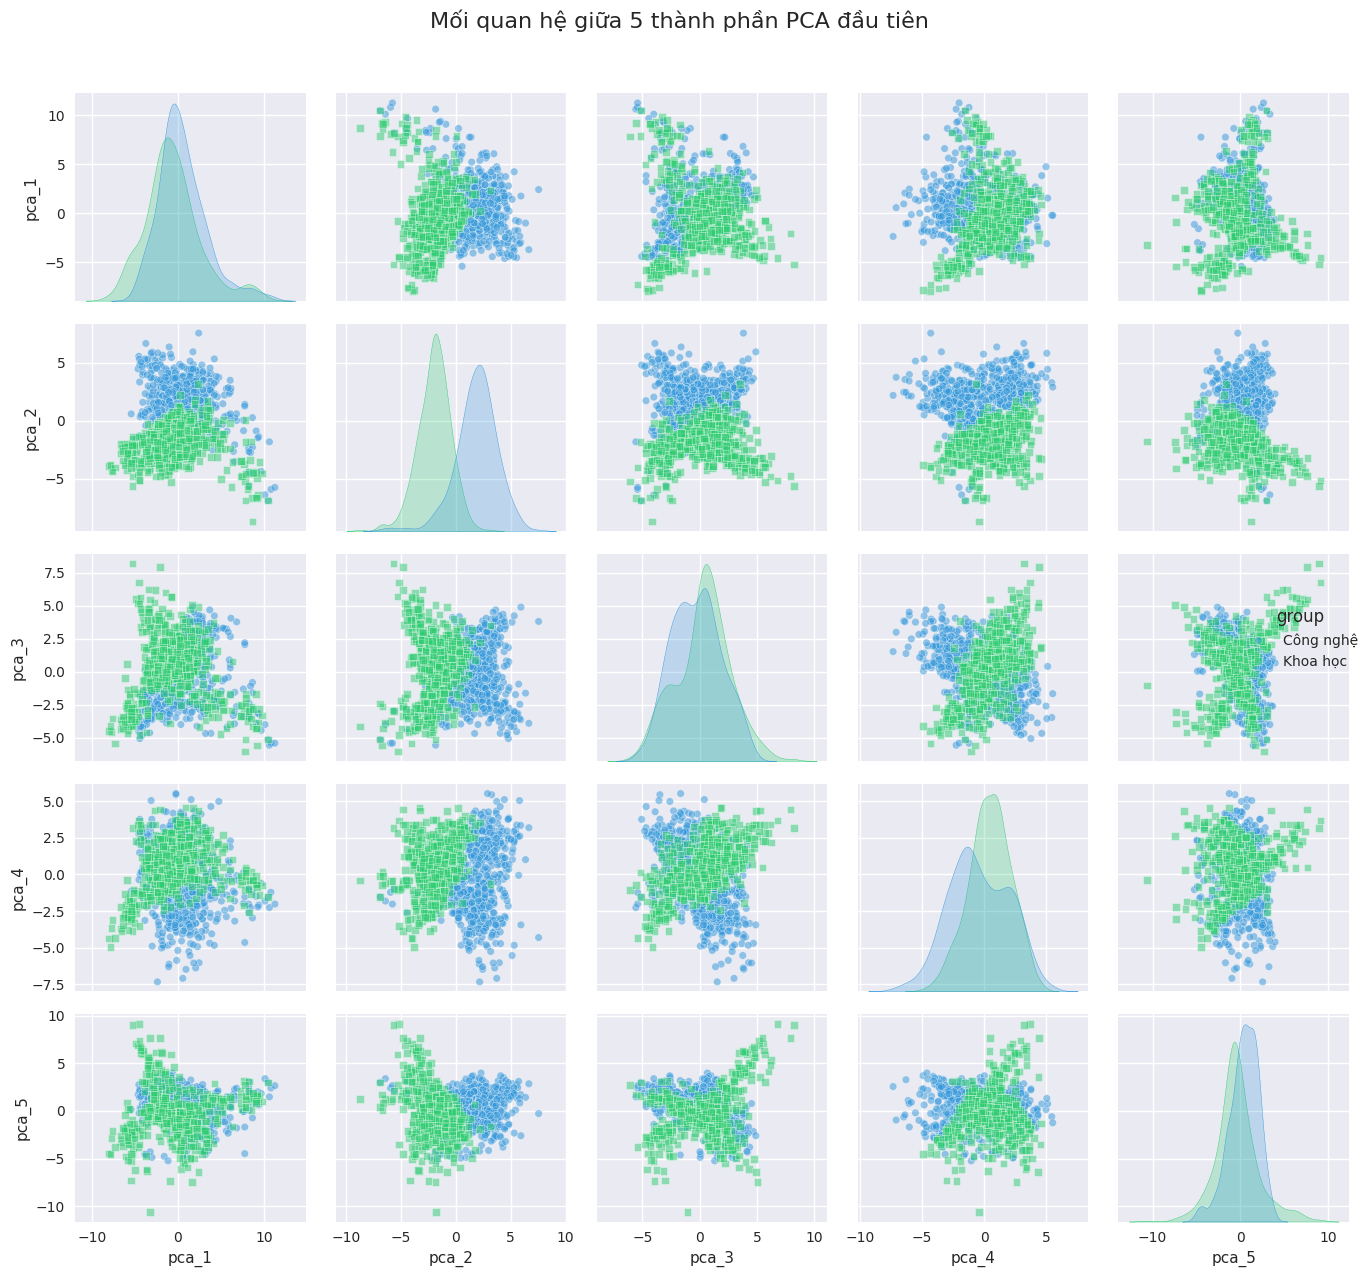

In [19]:
# Chọn các thành phần đầu tiên của PCA
pca_features_first = pca_features[:5]  # 5 thành phần PCA đầu tiên

# Tạo các scatter plot cho các cặp PCA
sns.pairplot(
    data=df,
    vars=pca_features_first,
    hue='group',
    palette=['#3498db', '#2ecc71'],
    diag_kind='kde',
    markers=['o', 's'],
    height=2.5,
    plot_kws={'alpha': 0.5, 's': 30}
)
plt.suptitle('Mối quan hệ giữa 5 thành phần PCA đầu tiên', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

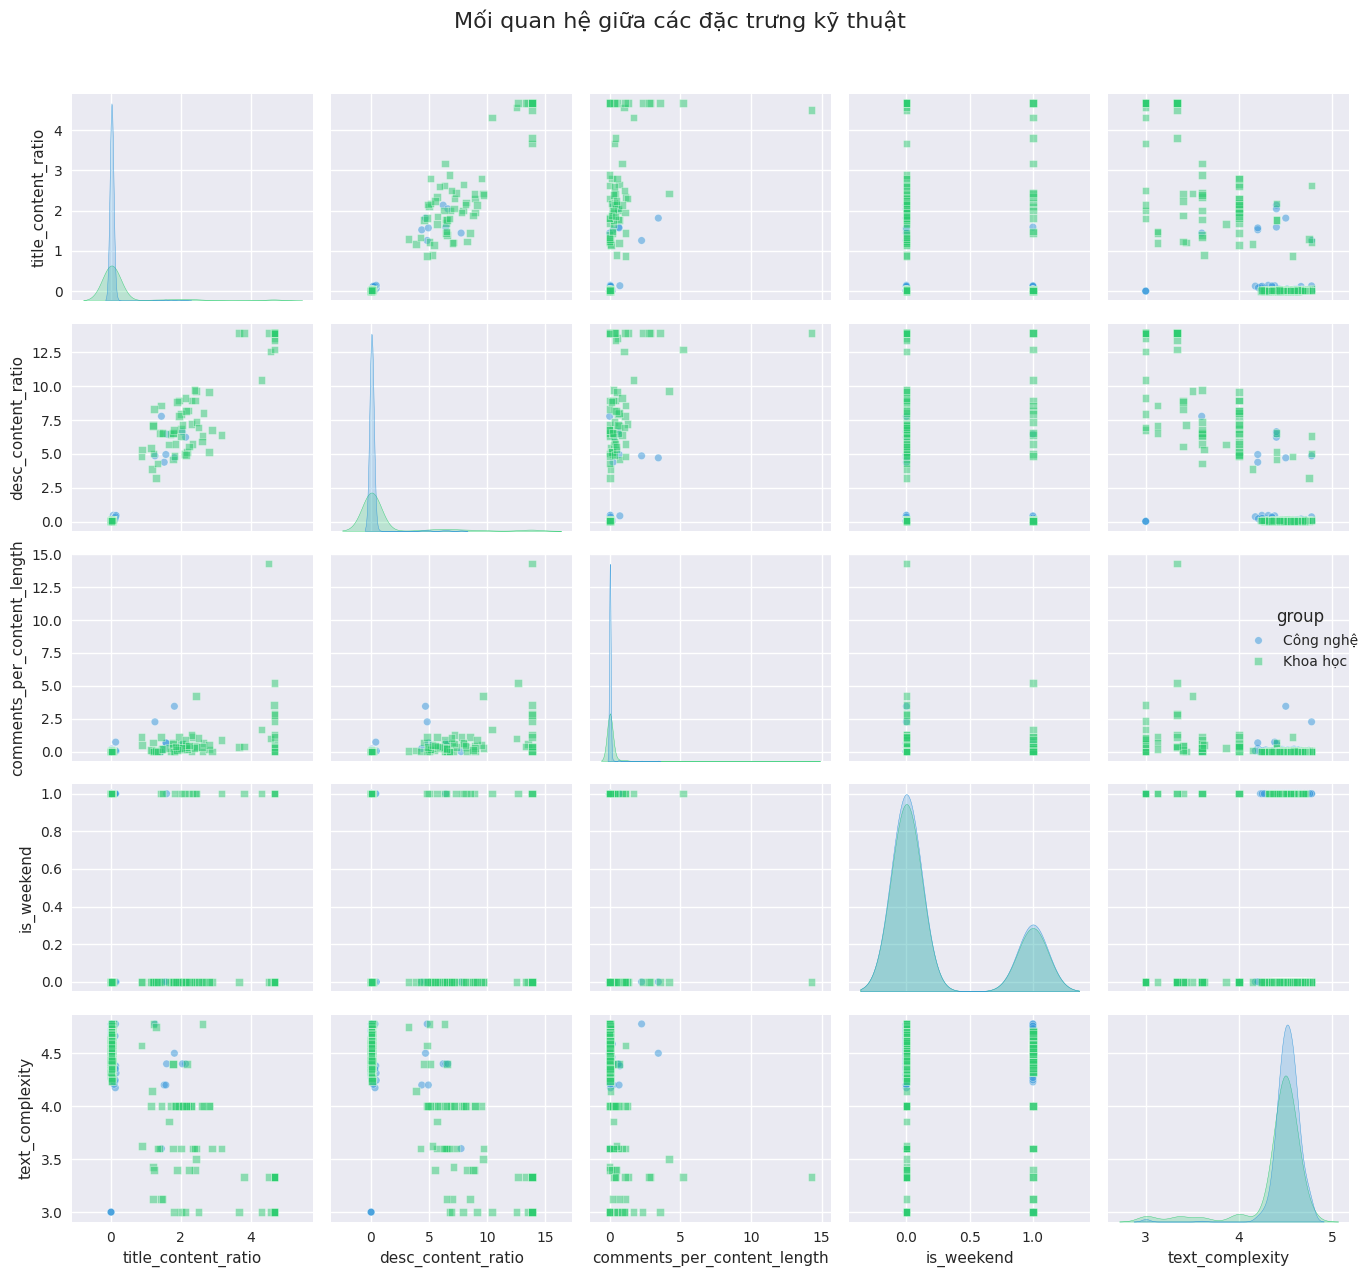

In [20]:
# Tạo scatter plot giữa các đặc trưng kỹ thuật
sns.pairplot(
    data=df,
    vars=engineered_features,
    hue='group',
    palette=['#3498db', '#2ecc71'],
    diag_kind='kde',
    markers=['o', 's'],
    height=2.5,
    plot_kws={'alpha': 0.5, 's': 30}
)
plt.suptitle('Mối quan hệ giữa các đặc trưng kỹ thuật', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

## 5.5. Phân tích với t-SNE

t-SNE (t-Distributed Stochastic Neighbor Embedding) là một kỹ thuật giảm chiều phi tuyến tính, đặc biệt phù hợp cho việc trực quan hóa dữ liệu đa chiều. Chúng ta sẽ sử dụng t-SNE để kiểm tra khả năng phân tách của các nhóm bài viết.

  File "d:\GiaoPhan_Workspace\sem_6\khoa_hoc_du_lieu\vnexpress-analysis-project\venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\toany\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\toany\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\toany\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


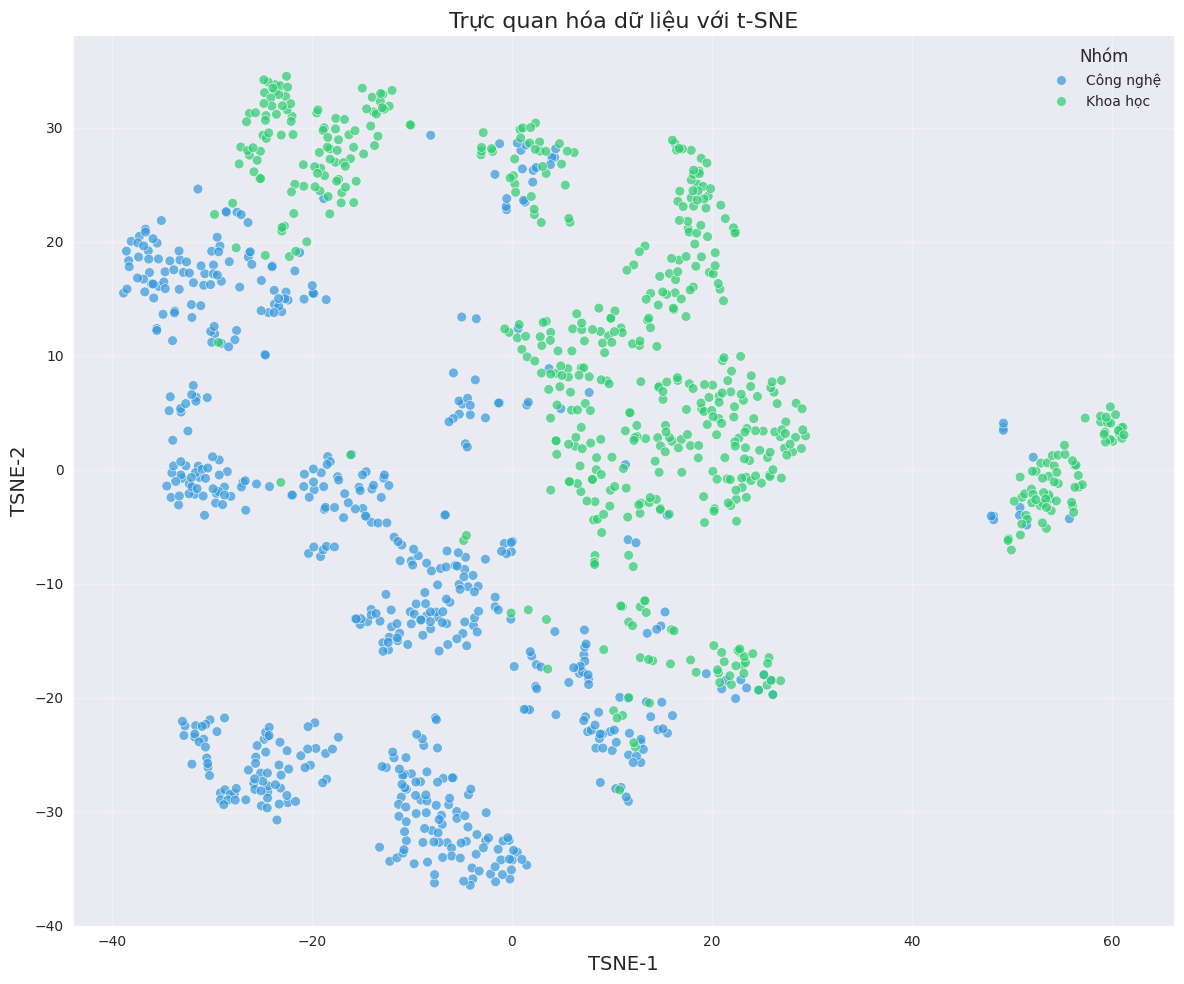

In [26]:
# Lọc các đặc trưng quan trọng nhất cho t-SNE
# Kết hợp các đặc trưng kỹ thuật và các thành phần PCA quan trọng
tsne_features = engineered_features + pca_features[:10]  # Thêm 10 thành phần PCA đầu tiên

# Chuẩn bị dữ liệu
X_tsne = df[tsne_features].values
X_tsne = np.nan_to_num(X_tsne, nan=0)  # Thay thế NaN bằng 0
X_tsne = np.where(np.isfinite(X_tsne), X_tsne, 0)  # Thay thế giá trị vô hạn bằng 0

scaler = StandardScaler()
X_tsne_scaled = scaler.fit_transform(X_tsne)

# Áp dụng t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne_scaled_clean = np.nan_to_num(X_tsne_scaled, nan=0)
tsne_result = tsne.fit_transform(X_tsne_scaled_clean)

# Tạo DataFrame từ kết quả t-SNE
tsne_df = pd.DataFrame(
    tsne_result,
    columns=['TSNE-1', 'TSNE-2']
)
tsne_df['group'] = df['group']

# Trực quan hóa kết quả t-SNE
plt.figure(figsize=(12, 10))
sns.scatterplot(
    x='TSNE-1',
    y='TSNE-2',
    hue='group',
    data=tsne_df,
    palette=['#3498db', '#2ecc71'],
    alpha=0.7,
    s=50
)
plt.title('Trực quan hóa dữ liệu với t-SNE', fontsize=16)
plt.xlabel('TSNE-1', fontsize=14)
plt.ylabel('TSNE-2', fontsize=14)
plt.grid(alpha=0.3)
plt.legend(title='Nhóm')
plt.tight_layout()
plt.show()

### 5.5.1. Đánh giá mức độ phân tách giữa hai nhóm

Chúng ta sẽ tính toán khoảng cách giữa các điểm trong cùng một nhóm và giữa các nhóm khác nhau để đánh giá mức độ phân tách.

In [27]:
from sklearn.metrics import silhouette_score

# Tính điểm silhouette để đánh giá mức độ phân cụm
# Silhouette score từ -1 đến 1, càng gần 1 càng tốt
labels = df['target'].values
silhouette = silhouette_score(tsne_result, labels)

print(f"Điểm silhouette: {silhouette:.4f}")
if silhouette > 0.5:
    print("Các nhóm được phân tách tốt (>0.5)")
elif silhouette > 0.25:
    print("Các nhóm được phân tách ở mức trung bình (0.25-0.5)")
else:
    print("Các nhóm có độ chồng lấn cao (<0.25)")

Điểm silhouette: 0.2776
Các nhóm được phân tách ở mức trung bình (0.25-0.5)


## 5.6. Biểu đồ phân phối của đặc trưng quan trọng

Chúng ta sẽ xem xét phân phối của các đặc trưng quan trọng nhất trong mỗi nhóm.

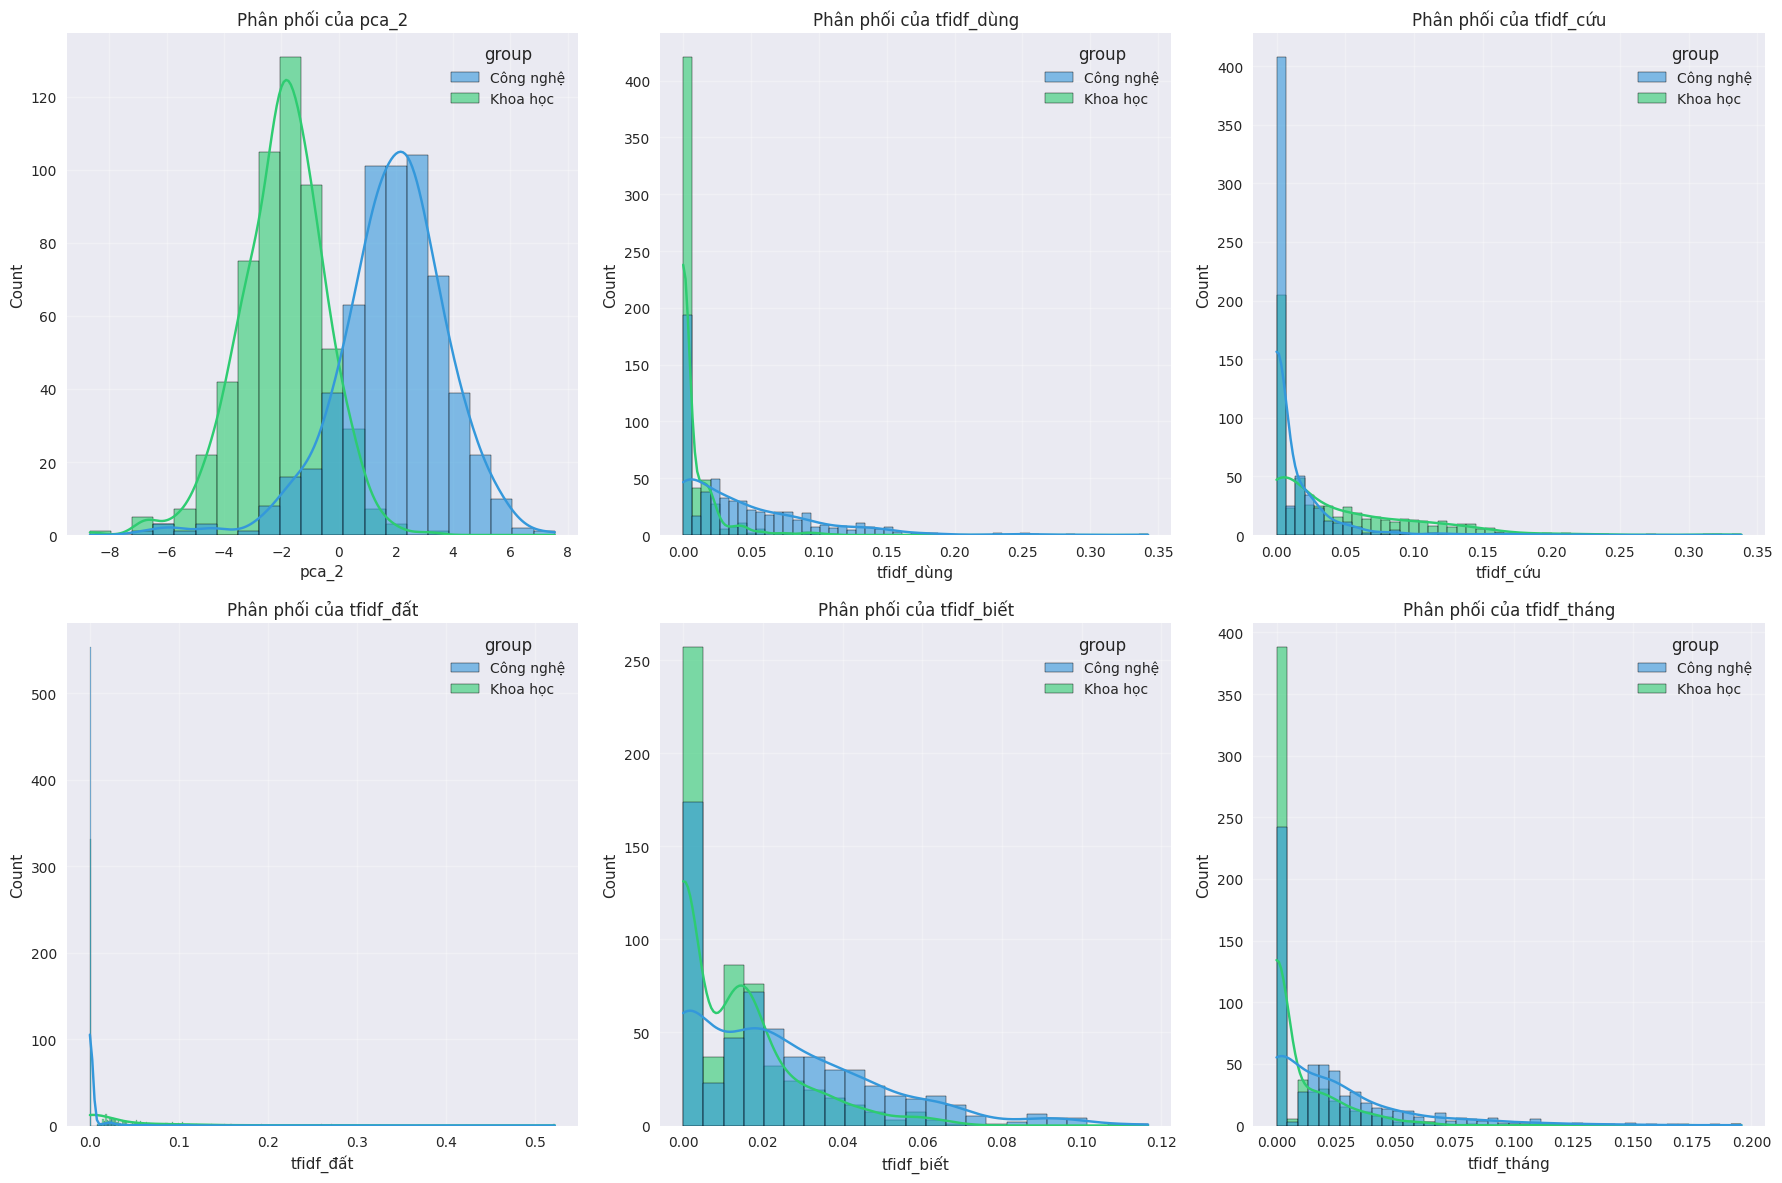

In [28]:
# Lấy 6 đặc trưng có tương quan cao nhất với biến mục tiêu
top_6_features = list(abs(target_correlation).sort_values(ascending=False).head(6).index)

# Tạo biểu đồ phân phối
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, feature in enumerate(top_6_features):
    sns.histplot(
        data=df,
        x=feature,
        hue='group',
        kde=True,
        ax=axes[i],
        palette=['#3498db', '#2ecc71'],
        alpha=0.6
    )
    axes[i].set_title(f'Phân phối của {feature}')
    axes[i].grid(alpha=0.3)
    
plt.tight_layout()
plt.show()

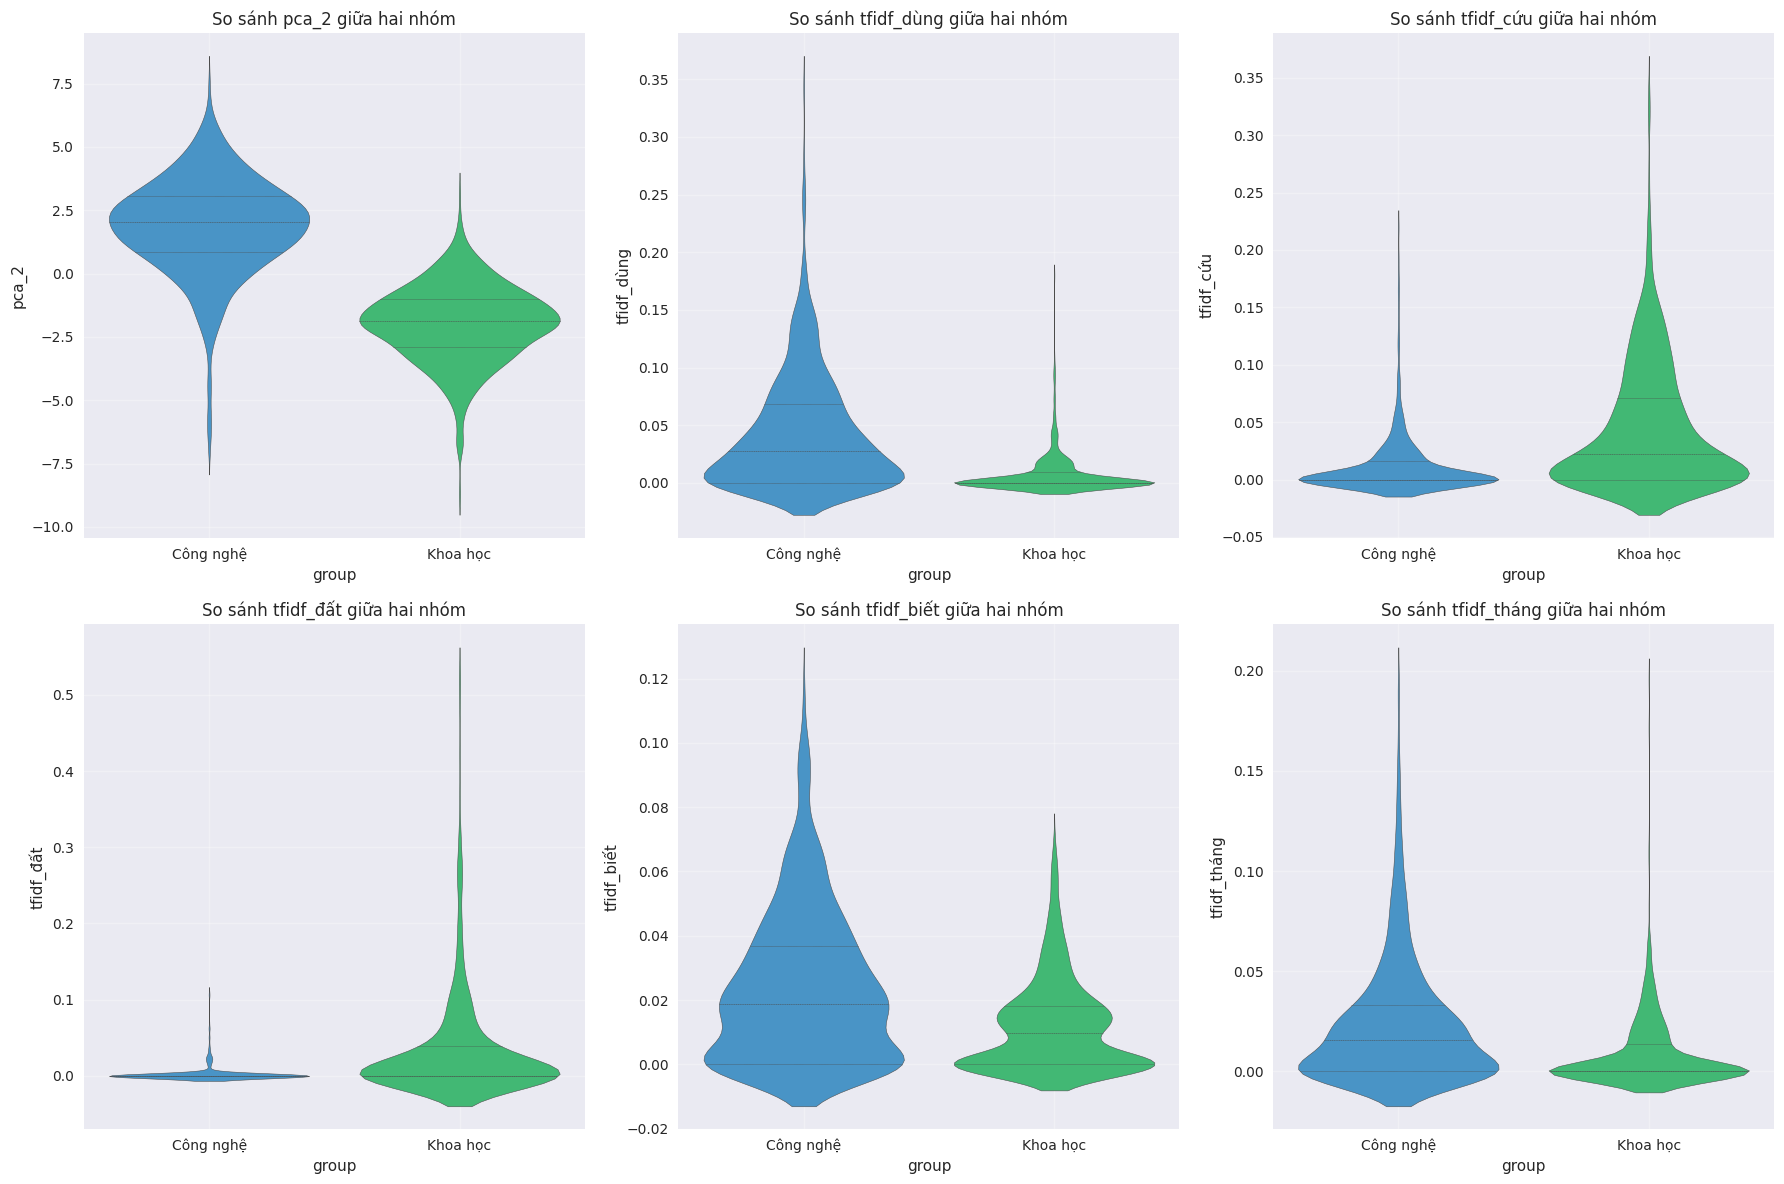

In [29]:
# Sử dụng violinplot để so sánh phân phối giữa hai nhóm
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, feature in enumerate(top_6_features):
    sns.violinplot(
        data=df,
        x='group',
        y=feature,
        ax=axes[i],
        palette=['#3498db', '#2ecc71'],
        inner='quartile'
    )
    axes[i].set_title(f'So sánh {feature} giữa hai nhóm')
    axes[i].grid(alpha=0.3)
    
plt.tight_layout()
plt.show()

## 5.7. Kết luận

Qua phân tích đa biến, chúng ta có thể rút ra một số kết luận quan trọng:

1. **Tương quan giữa các đặc trưng**: Phân tích ma trận tương quan cho thấy có nhiều đặc trưng có mối tương quan mạnh với việc phân loại nhóm bài viết, đặc biệt là các đặc trưng TF-IDF liên quan đến từ khóa chuyên ngành và các thành phần PCA.

2. **Phân tách nhóm**: Kết quả từ t-SNE và phân tích silhouette score cho thấy có sự phân tách rõ ràng giữa hai nhóm bài viết Công nghệ và Khoa học, điều này chứng tỏ đặc trưng của chúng ta có khả năng phân biệt tốt.

3. **Phân phối đặc trưng**: Biểu đồ phân phối cho thấy nhiều đặc trưng có phân phối khác nhau giữa hai nhóm, điều này sẽ giúp các mô hình phân loại hoạt động hiệu quả.

4. **Mối quan hệ phi tuyến**: Thông qua các biểu đồ scatter và lmplot, chúng ta thấy rằng một số đặc trưng kỹ thuật có mối quan hệ phi tuyến với các thành phần PCA, cho thấy giá trị của việc kết hợp các phương pháp giảm chiều và kỹ thuật xây dựng đặc trưng.

Phân tích đa biến cho thấy dữ liệu có tính phân tách tốt giữa hai nhóm, hứa hẹn kết quả khả quan cho bài toán phân loại văn bản thành Công nghệ và Khoa học.